In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchmetrics
!pip install segmentation-models-pytorch

In [3]:
import os
import sys
sys.path.append('..')

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader
from pathlib import Path
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = '/content/drive/Othercomputers/내 Mac/Road_Lane_segmentation'
else:
    PROJECT_ROOT = Path.cwd().parent

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용)
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

from src.utils import setup_workspace, load_config, get_device, seed
from src.data import DatasetLoader, get_transforms, split_dataset
from src.models.losses import get_loss
from src.inference import Inferencer, visualize_prediction, visualize_comparison

Environment: Colab
PROJECT_ROOT: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Current working directory: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation


In [6]:
!nvidia-smi

Tue Jan 20 07:24:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
SEED = 42
DATA_ROOT = "dataset/Multi Camera Semantic Segmentation"
CONFIG_ROOT = "configs/config.yaml"

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

Env: Colab | Root: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Device: NVIDIA A100-SXM4-80GB


device(type='cuda')

In [ ]:
config = load_config(CONFIG_ROOT)
config

{'data': {'root': 'dataset/Multi_Camera_Semantic_Segmentation',
  'num_classes': 62,
  'img_size': [768, 576]},
 'model': {'name': 'deeplabv3_resnet101', 'pretrained': True},
 'training': {'batch_size': 16,
  'accumulation_steps': 2,
  'epochs': 80,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'dropout': 0.1,
  'early_stop': 10,
  'num_workers': 4},
 'checkpoint': {'dir': 'checkpoints', 'exp_name': 'exp1'},
 'loss': {'type': 'ce+dice',
  'weights': {'ce': 0.5, 'dice': 0.5},
  'ignore_index': 255},
 'wandb': {'enabled': True,
  'project': 'Road_Lane_Segmentation',
  'run_name': 'baseline',
  'tags': ['deeplabv3', 'segmentation']}}

In [ ]:
from scripts.train import Trainer

trainer = Trainer("configs/config.yaml")
trainer.train()

INFO:Trainer:Gradient accumulation enabled with 2 steps.


Device: NVIDIA A100-SXM4-80GB
Train samples: 515
Val samples: 182
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:05<00:00, 48.6MB/s]
INFO:Trainer:Loss: ce+dice
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validating: 100%|██████████| 12/12 [02:29<00:00, 12.47s/it]
INFO:Trainer:Epoch 1/80 | Train Loss: 1.0863 | Val Loss: 0.6766 | mIoU: 0.0742 | Accuracy: 0.1065 | Dice: 0.0882
INFO:Trainer:Logging validation images to W&B for epoch 1...
INFO:Trainer:Saved: checkpoints/deeplabv3_resnet101_exp1/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
INFO:Trainer:Epoch 2/80 | Train Loss: 0.7020 | Val Loss: 0.6689 | mIoU: 0.0965 | Accuracy: 0.1299 | Dice: 0.1184
INFO:Trainer:Saved: checkpoints/deeplabv3_resnet101_exp1/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
INFO:Trainer:Epoch 3/80 | Train Loss: 0.6227 | Val Loss: 0.3925 | mIoU: 0.1383 | Accuracy: 0.1809 | Dice: 0.1647
INFO:Trainer:Saved: checkpoints/deeplabv3_resnet101_exp1/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:08<00:00,  1

accuracy,▁▁▂▂▂▄▄▄▄▄▅▆▆▅▆▆▆▆▆▇▆▆▆▇▇▇▇█▇▇█▇▇██▆▄▆██
dice,▁▂▂▂▂▄▃▄▄▅▅▅▆▆▆▇▆▇▆▅▃▆▇▇▇▇██████▆▃▆▇▇▇██
miou,▁▂▃▄▄▄▄▄▅▆▅▆▆▇▆▆▅▆▃▆▆▇▇████████▇▇█▆▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,▆▆▃▃█▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▅▂▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.5368
best_miou,0.42979
dice,0.53146
early_stopped,True
miou,0.41996
stopped_epoch,73


INFO:Trainer:Training complete. Best mIoU: 0.4298


In [ ]:
from scripts.evaluate import Evaluator

checkpoint_path = "checkpoints/deeplabv3_resnet101_exp1/best.pt"
evaluator = Evaluator(config_path=CONFIG_ROOT, checkpoint_path=checkpoint_path)
metrics = evaluator.evaluate()
metrics

Device: NVIDIA A100-SXM4-80GB


INFO:Evaluator:Loaded 182 samples from val split
INFO:Evaluator:Number of classes: 62


Val samples: 182
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:03<00:00, 52.0MB/s]
INFO:Evaluator:Model: deeplabv3_resnet101
INFO:Evaluator:Checkpoint: checkpoints/deeplabv3_resnet101_exp1/best.pt
Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
INFO:Evaluator:Evaluation Results | mIoU: 0.4298 | Accuracy: 0.5227 | Dice: 0.5365


{'miou': 0.42978569865226746,
 'accuracy': 0.5227274894714355,
 'dice': 0.5365280508995056}

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame([metrics])
metrics_df

,miou,accuracy,dice
0,0.429786,0.522727,0.536528


In [6]:
import numpy as np

def create_colormap(num_classes):
    colormap = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]  # background는 검정
    return colormap

def mask_to_color(mask, colormap):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in enumerate(colormap):
        color_mask[mask == class_id] = color
    return color_mask

In [7]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

def visualize_segmentation(
    model,
    dataloader,
    device,
    num_classes,
    num_samples=3,
    alpha=0.5
):
    """모델 추론 결과를 시각화"""
    model.eval()
    colormap = create_colormap(num_classes)

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            preds = outputs.argmax(dim=1)

            images = images.cpu()
            masks = masks.cpu()
            preds = preds.cpu()

            for i in range(min(num_samples, images.size(0))):
                img_tensor = images[i].clone()

                # 역정규화 (De-normalization)
                for c in range(3):
                    img_tensor[c] = img_tensor[c] * STD[c] + MEAN[c]

                # Tensor → Numpy Image
                img_np = img_tensor.permute(1, 2, 0).numpy()
                img_np = np.clip(img_np, 0, 1)

                gt_mask = masks[i].numpy()
                pred_mask = preds[i].numpy()

                gt_color = mask_to_color(gt_mask, colormap)
                pred_color = mask_to_color(pred_mask, colormap)

                overlay = img_np * (1 - alpha) + (pred_color / 255.0) * alpha

                fig, axes = plt.subplots(1, 4, figsize=(24, 6))

                axes[0].imshow(img_np)
                axes[0].set_title("Image")

                axes[1].imshow(gt_color)
                axes[1].set_title("GT Mask")

                axes[2].imshow(pred_color)
                axes[2].set_title("Pred Mask")

                axes[3].imshow(overlay)
                axes[3].set_title("Overlay (Prediction)")

                for ax in axes:
                    ax.axis("off")

                plt.tight_layout()
                plt.show()

            break  # 첫 batch만 시각화

In [ ]:
visualize_segmentation(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    num_samples=3
)

---

### Class Weights (inverse) & Scheduler (cosine) - exp1

In [ ]:
SEED = 42
DATA_ROOT = "dataset/Multi_Camera_Semantic_Segmentation"
CONFIG_ROOT = "configs/config.yaml"

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

print()

config = load_config(CONFIG_ROOT)
config

Env: Colab | Root: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Device: Tesla T4



{'data': {'root': 'dataset/Multi_Camera_Semantic_Segmentation',
  'num_classes': 62,
  'img_size': [768, 576]},
 'model': {'name': 'deeplabv3_resnet101', 'pretrained': True},
 'training': {'batch_size': 16,
  'accumulation_steps': 2,
  'epochs': 100,
  'lr': 0.0007,
  'weight_decay': 0.0001,
  'dropout': 0.2,
  'early_stop': 15,
  'num_workers': 8,
  'scheduler': {'enabled': True, 'type': 'cosine', 'min_lr': 1e-05}},
 'checkpoint': {'dir': 'checkpoints', 'exp_name': 'class_weight_exp1'},
 'loss': {'type': 'ce+dice',
  'weights': {'ce': 0.5, 'dice': 0.5},
  'ignore_index': 255,
  'class_weights': {'enabled': True,
   'method': 'inverse',
   'beta': 0.999,
   'normalize': True}},
 'wandb': {'enabled': True,
  'project': 'Road_Lane_Segmentation',
  'run_name': 'class_weight_exp1',
  'tags': ['deeplabv3', 'segmentation'],
  'num_samples': 2}}

In [ ]:
from scripts.train import Trainer

trainer = Trainer("configs/config.yaml")
trainer.train()

In [ ]:
from scripts.evaluate import Evaluator

checkpoint_path = "checkpoints/deeplabv3_resnet101_class_weight_exp1/best.pt"
evaluator = Evaluator(config_path=CONFIG_ROOT, checkpoint_path=checkpoint_path)
metrics = evaluator.evaluate()
metrics

Device: Tesla T4


INFO:Evaluator:Loaded 182 samples from val split
INFO:Evaluator:Number of classes: 62


Val samples: 182
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:03<00:00, 58.6MB/s]
INFO:Evaluator:Model: deeplabv3_resnet101
INFO:Evaluator:Checkpoint: checkpoints/deeplabv3_resnet101_class_weight_exp1/best.pt
Evaluating: 100%|██████████| 12/12 [01:44<00:00,  8.72s/it]
INFO:Evaluator:Evaluation Results | mIoU: 0.4152 | Accuracy: 0.5278 | Dice: 0.5351


{'miou': 0.41521286964416504,
 'accuracy': 0.5278294086456299,
 'dice': 0.5350657105445862}

In [ ]:
visualize_segmentation(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    num_samples=3
)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(
    model,
    dataloader,
    device,
    num_classes,
    ignore_index=255
):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            preds = outputs.argmax(dim=1)

            preds = preds.view(-1).cpu().numpy()
            targets = masks.view(-1).cpu().numpy()

            valid_mask = targets != ignore_index
            preds = preds[valid_mask]
            targets = targets[valid_mask]

            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(
        all_targets,
        all_preds,
        labels=list(range(num_classes))
    )

    return cm

def plot_confusion_matrix(
    cm,
    class_names=None,
    normalize=True,
    figsize=(8, 6)
):
    if normalize:
        cm = cm.astype(np.float32)
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-6)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.colorbar()

    if class_names is not None:
        plt.xticks(range(len(class_names)), class_names, rotation=90)
        plt.yticks(range(len(class_names)), class_names)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

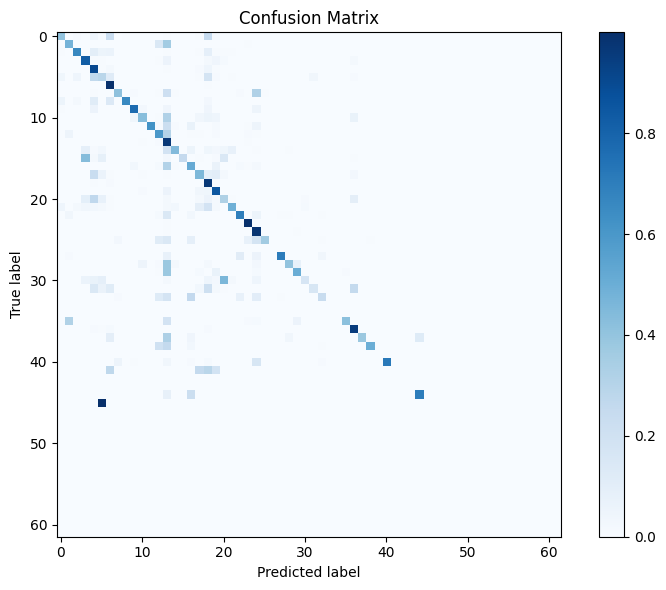

In [ ]:
ignore_index = evaluator.config.get("loss", {}).get("ignore_index", 255)

cm = compute_confusion_matrix(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    ignore_index=ignore_index
)

plot_confusion_matrix(cm)

In [12]:
import pandas as pd

class_info_path = "dataset/multi_class_info.csv"
class_info = pd.read_csv(class_info_path)
class_info.head()

,class_id,class_name,count
0,0,pole,14713
1,1,whdot,6806
2,2,traffic sign,5151
3,3,car,3900
4,4,building,3427


In [ ]:
class_info['class_name'].unique()

array(['pole', 'whdot', 'traffic sign', 'car', 'building', 'static',
       'sky', 'crosswalk', 'traffic light', 'sidewalk', 'curb', 'yesol',
       'whsol', 'road', 'rubber cone', 'license plate',
       'general road mark', 'wall', 'vegetation', 'guard rail', 'truck',
       'dynamic', 'forward', 'ego vehicle', 'protection zone',
       'stop line', 'yedot', 'left', 'guidance line', 'blsol', 'bus',
       'bridge', 'right', 'person', 'ground', 'bldot', 'tunnel',
       'number 0', 'parking', 'leftU', 'speed bump',
       'prohibition (X mark)', 'bicycle', 'number 5', 'number 6',
       'caravan', 'motorcycle', 'terrain', 'number 4', 'ground animal',
       'water', 'number 3', 'train', 'leftU-forward', 'rider', 'fence',
       'number 7', 'right-forward', 'trailer', 'number 1', 'polegroup',
       'rail track'], dtype=object)

In [ ]:
# 차선 관련 키워드 정의
lane_keywords = [
    'whdot', 'whsol', 'yedot', 'yesol', 'bldot', 'blsol',
    'stop line', 'guidance line', 'general road mark', 'crosswalk',
    'forward', 'left', 'right', 'leftU', 'leftU-forward', 'right-forward'
]

selected_lane_classes = class_info[class_info['class_name'].isin(lane_keywords)]
lane_ids = selected_lane_classes['class_id'].tolist()
lane_names = selected_lane_classes['class_name'].tolist()

def plot_specific_confusion_matrix(cm, selected_ids, selected_names, normalize=True):
    # 전체 CM에서 선택한 클래스의 행/열만 추출
    specific_cm = cm[np.ix_(selected_ids, selected_ids)]

    if normalize:
        # 행 단위 노멀라이즈 (해당 클래스 중 몇 %를 맞췄는지)
        specific_cm = specific_cm.astype('float') / (specific_cm.sum(axis=1, keepdims=True) + 1e-7)
        title = "Normalized Lane Confusion Matrix"
        fmt = '.2f'
    else:
        title = "Lane Confusion Matrix (Pixel Counts)"
        fmt = 'd'

    plt.figure(figsize=(14, 12))
    plt.imshow(specific_cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.colorbar()

    tick_marks = np.arange(len(selected_names))
    plt.xticks(tick_marks, selected_names, rotation=90)
    plt.yticks(tick_marks, selected_names)

    # 수치 표시 (글자가 겹치지 않게 조절)
    thresh = specific_cm.max() / 2.
    for i, j in np.ndindex(specific_cm.shape):
        plt.text(j, i, format(specific_cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if specific_cm[i, j] > thresh else "black",
                 fontsize=9)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

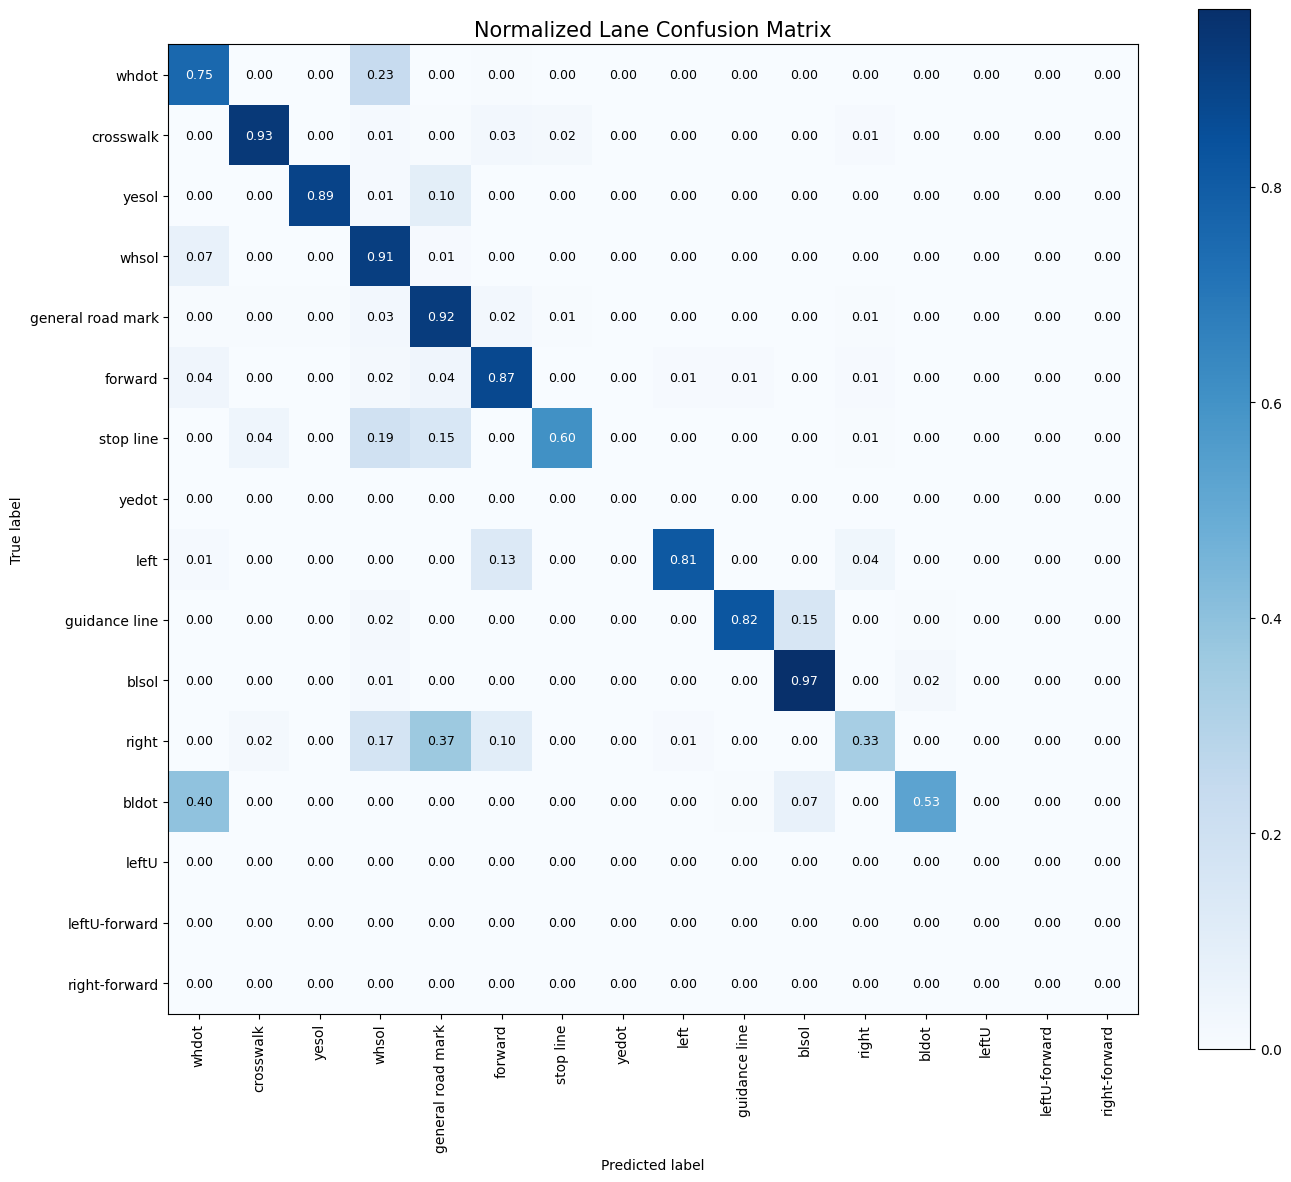

In [ ]:
plot_specific_confusion_matrix(cm, lane_ids, lane_names, normalize=True)

### Class Weights (Effective) & Scheduler (cosine) - exp2

In [4]:
SEED = 42
DATA_ROOT = "dataset/Multi_Camera_Semantic_Segmentation"
CONFIG_ROOT = "configs/config.yaml"

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

print()

config = load_config(CONFIG_ROOT)
config

Env: Colab | Root: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Device: NVIDIA A100-SXM4-80GB



{'data': {'root': 'dataset/Multi_Camera_Semantic_Segmentation',
  'num_classes': 62,
  'img_size': [768, 576]},
 'model': {'name': 'DeepLabV3Plus',
  'encoder': 'resnet101',
  'pretrained': True},
 'training': {'batch_size': 16,
  'accumulation_steps': 3,
  'epochs': 100,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'dropout': 0.2,
  'early_stop': 15,
  'num_workers': 8,
  'scheduler': {'enabled': True, 'type': 'cosine', 'min_lr': 1e-05}},
 'checkpoint': {'dir': 'checkpoints', 'exp_name': 'class_weight_exp2'},
 'loss': {'type': 'ce+dice',
  'weights': {'ce': 0.5, 'dice': 0.5},
  'ignore_index': 255,
  'focal_gamma': 2.0,
  'class_weights': {'enabled': True,
   'method': 'effective',
   'beta': 0.999,
   'normalize': True}},
 'wandb': {'enabled': True,
  'project': 'Road_Lane_Segmentation',
  'run_name': 'class_weight_exp2',
  'tags': ['deeplabv3', 'segmentation'],
  'num_samples': 2}}

In [5]:
from scripts.train import Trainer

trainer = Trainer("configs/config.yaml")
trainer.train()

INFO:Trainer:Gradient accumulation enabled with 3 steps.


Device: NVIDIA A100-SXM4-80GB
Train samples: 515
Val samples: 182


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

INFO:Trainer:Model: DeepLabV3Plus + resnet101 (CNN, 45.7M params)
INFO:Trainer:Class weights enabled (method: effective)
INFO:Trainer:Loss: ce+dice
INFO:Trainer:Scheduler: CosineAnnealingLR(min_lr=1e-05)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validating: 100%|██████████| 12/12 [01:31<00:00,  7.60s/it]
INFO:Trainer:Epoch 1/100 | Train Loss: 1.6135 | Val Loss: 1.1144 | mIoU: 0.0890 | Accuracy: 0.8086 | Dice: 0.1030 | LR: 0.001000
INFO:Trainer:Logging validation images to W&B for epoch 1...
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_weight_exp2/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
INFO:Trainer:Epoch 2/100 | Train Loss: 1.1456 | Val Loss: 1.0568 | mIoU: 0.0881 | Accuracy: 0.8262 | Dice: 0.1035 | LR: 0.001000
INFO:Trainer:EarlyStopping counter: 1/15
Validating: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
INFO:Trainer:Epoch 3/100 | Train Loss: 1.0901 | Val Loss: 0.8687 | mIoU: 0.0957 | Accuracy: 0.8256 | Dice: 0.1139 | LR: 0.000999
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_weight_exp2/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:06<00:00,  1

accuracy,▂▃▃▄▃▆▇▄▆▄▁▆▇▇▇▅▆▇▇▇▇███████████████████
dice,▁▁▁▂▂▄▄▄▄▄▃▃▄▃▄▅▄▃▄▄▅▅▆▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇
learning_rate,█████████████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁
miou,▁▁▁▁▂▃▄▄▄▄▄▃▄▅▅▃▄▄▅▅▅▆▅▆▆▆▇▇▇▇██▇▇▇▇▇█▇▇
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁
val_loss,█▄▅▄▄▃▂▂▂▂▄▄▄▂▆▂▂▁▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.942
best_miou,0.37438
dice,0.44173
early_stopped,True
learning_rate,0.00015


INFO:Trainer:Training complete. Best mIoU: 0.3744


In [10]:
from scripts.evaluate import Evaluator

checkpoint_path = "checkpoints/DeepLabV3Plus_resnet101_class_weight_exp2/best.pt"
evaluator = Evaluator(config_path=CONFIG_ROOT, checkpoint_path=checkpoint_path)
metrics = evaluator.evaluate()
metrics

Device: NVIDIA A100-SXM4-80GB


INFO:Evaluator:Loaded 182 samples from val split
INFO:Evaluator:Number of classes: 62


Val samples: 182


INFO:Evaluator:Model: DeepLabV3Plus + resnet101 (45.7M params)
INFO:Evaluator:Checkpoint: checkpoints/DeepLabV3Plus_resnet101_class_weight_exp2/best.pt
Evaluating: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
INFO:Evaluator:Evaluation Results | mIoU: 0.3744 | Accuracy: 0.9394 | Dice: 0.4867


{'miou': 0.3743840456008911,
 'accuracy': 0.9393776059150696,
 'dice': 0.48668426275253296}

In [11]:
visualize_segmentation(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    num_samples=3
)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
ignore_index = evaluator.config.get("loss", {}).get("ignore_index", 255)

cm = compute_confusion_matrix(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    ignore_index=ignore_index
)

In [18]:
# 차선 관련 키워드 정의
lane_keywords = [
    'whdot', 'whsol', 'yedot', 'yesol', 'bldot', 'blsol',
    'stop line', 'guidance line', 'general road mark', 'crosswalk',
    'forward', 'left', 'right', 'leftU', 'leftU-forward', 'right-forward'
]

selected_lane_classes = class_info[class_info['class_name'].isin(lane_keywords)]
lane_ids = selected_lane_classes['class_id'].tolist()
lane_names = selected_lane_classes['class_name'].tolist()

def plot_specific_confusion_matrix(cm, selected_ids, selected_names, normalize=True):
    # 전체 CM에서 선택한 클래스의 행/열만 추출
    specific_cm = cm[np.ix_(selected_ids, selected_ids)]

    if normalize:
        # 행 단위 노멀라이즈 (해당 클래스 중 몇 %를 맞췄는지)
        specific_cm = specific_cm.astype('float') / (specific_cm.sum(axis=1, keepdims=True) + 1e-7)
        title = "Normalized Lane Confusion Matrix"
        fmt = '.2f'
    else:
        title = "Lane Confusion Matrix (Pixel Counts)"
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    plt.imshow(specific_cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.colorbar()

    tick_marks = np.arange(len(selected_names))
    plt.xticks(tick_marks, selected_names, rotation=90)
    plt.yticks(tick_marks, selected_names)

    # 수치 표시 (글자가 겹치지 않게 조절)
    thresh = specific_cm.max() / 2.
    for i, j in np.ndindex(specific_cm.shape):
        plt.text(j, i, format(specific_cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if specific_cm[i, j] > thresh else "black",
                 fontsize=9)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

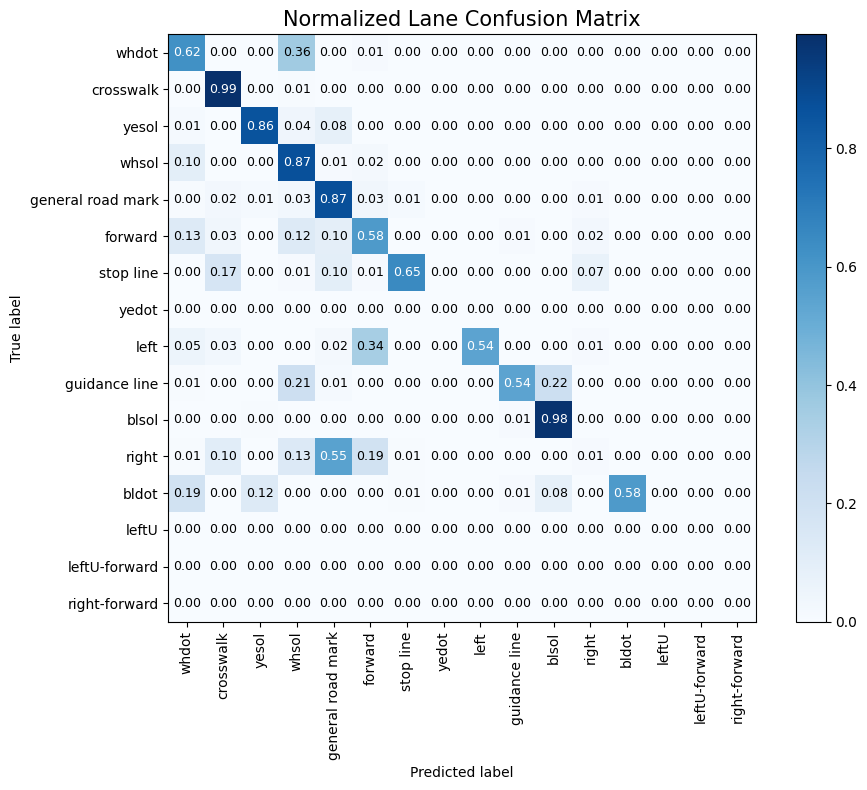

In [19]:
plot_specific_confusion_matrix(cm, lane_ids, lane_names, normalize=True)